In [1]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script to run runme_terminus_sensitivity_basic.m translted from Matlab to Python
# Mikayla Pascual 01/03/23
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#import 
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

import matplotlib.pyplot as plt

In [41]:
md = loadmodel('./Models/SAtoES_Param.nc')

md.transient.issmb = 0
md.transient.isthermal = 0
md.thermal.isenthalpy = 0


Opening ./Models/SAtoES_Param.nc for reading 
group toolkits is empty
group results is empty


In [42]:
## Inversion
print('Setting up the inversion')
# Control general
md.inversion=m1qn3inversion(md.inversion)
md.inversion.iscontrol=1
md.verbose.solution = False
md.verbose.control = True
md.verbose.qmu = False

# Cost functions
print(' -> Setting cost function values')
md.inversion.cost_functions=[101, 103, 501]; #Abs, Log, reg
md.inversion.cost_functions_coefficients=np.ones([md.mesh.numberofvertices,len(md.inversion.cost_functions)])
md.inversion.cost_functions_coefficients[:,0]=2000
md.inversion.cost_functions_coefficients[:,1]=40
md.inversion.cost_functions_coefficients[:,2]=1.6e-06

# Where vel==0, set coefficients to 0 (i.e., don't try to match this in model)
print(' -> Removing vel==0 obs from inversion')
pos = md.inversion.vel_obs == 0
md.inversion.cost_functions_coefficients[pos,0] = 0
md.inversion.cost_functions_coefficients[pos,1] = 0

# Controls
print(' -> Setting control parameters')
md.inversion.control_parameters=['FrictionCoefficient']
md.inversion.maxsteps=50
md.inversion.maxiter =100
md.inversion.min_parameters=0.05*np.ones(md.mesh.numberofvertices)
md.inversion.max_parameters=200*np.ones(md.mesh.numberofvertices)
md.inversion.control_scaling_factors=1

# Additional parameters
md.stressbalance.restol=0.01
md.stressbalance.reltol=0.1
md.stressbalance.abstol=np.nan
#md.stressbalance.requested_outputs={'default','DeviatoricStressxx','DeviatoricStressyy','DeviatoricStressxy'}

md.friction.coupling = 2

# Go solve
print(' -> Solve')
#md.verbose.solution=True
from socket import gethostname
from generic import generic
md.cluster = generic('name', gethostname(), 'np', 4)
md.settings.waitonlock = np.inf
md.cluster.interactive = 0
md = solve(md,'Stressbalance')

Setting up the inversion
converting inversion to m1qn3inversion
 -> Setting cost function values
 -> Removing vel==0 obs from inversion
 -> Setting control parameters
 -> Solve
uploading input file and queueing script
launching solution sequence on remote cluster
waiting for /efs/issm-new/python-modules/repos/trunk-jpl-denis/execution/Greenland-02-09-2023-16-37-55-5780/Greenland.lock hold on... (Ctrl+C to exit)


In [43]:
from loadresultsfromcluster import loadresultsfromcluster
md = loadresultsfromcluster(md)

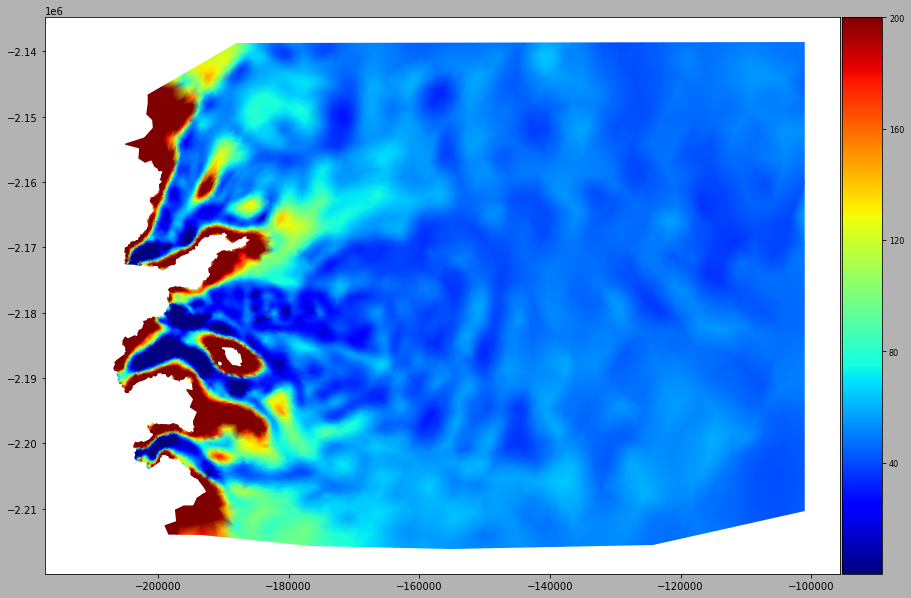

In [44]:
fig = plt.figure(figsize=(15,15))
plotmodel(md, 'data', md.results.StressbalanceSolution.FrictionCoefficient[:,0], \
          'mask', md.mask.ice_levelset<0, 'colormap', 'jet')


In [6]:
# Save
from export_netCDF import export_netCDF
export_netCDF(md, 'Models/SAtoES_Inversion.nc')

field md.solidearth.external is None


/efs/issm-new/python-modules/repos/trunk-jpl-denis/src/m/contrib/defleurian/netCDF/export_netCDF.py:394: RuntimeWarning: invalid value encountered in remainder
  IsInt = np.sum(np.mod(var, 1)) == 0 and np.all(abs(var) < 2147483647) and len(var) > 0


qmu is skipped until it is more stable


## Check against the inversion from Matlab

In [45]:
md_check = loadmodel('Models/SAtoES_Inversion_fromMatlab.nc')

Opening Models/SAtoES_Inversion_fromMatlab.nc for reading 
group toolkits is empty
empty init


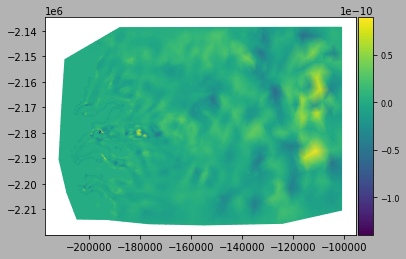

In [50]:
plotmodel(md, 'data', md.results.StressbalanceSolution.FrictionCoefficient[:,0] - md_check.results.StressbalanceSolution.FrictionCoefficient)

Friction coefficient differences are < 1e-10 so we're good to go!